In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10


# import logging
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
np.random.seed(SEED)

# Reset do estilo de cores do matplotlib 

In [2]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

# Sistema Recomendação Vinhos

- Carregar dados de vinho e separar vinhos tinto e branco: tintos para desenvolvimento/operação e vinhos brancos para novidade 
- Treinamento de modelo com regressão logística do sklearn no pyCaret
- Registros das etapas de processamento como runs
- Registro do modelo com threshold de precisão mínimo de 70% em Staging
- Aplicação Online: recomendação de vinhos
    - Consumo da base de dados de operação
    - Utilização do requests para fazer o POST e recuperar a predição do modelo
    - Propor os 5 vinhos de alta qualidade de maior nível alcólico (print data frame)
- Aplicação de Monitoramento: pipeline de monitoramento
    - Revalidacao da base de operacao para amostras de controle (simulação especialista)
    - Leitura da base de desenvolvimento (treino+teste)
    - Alarme de amostra de controle
    - Alarme com amostras de novidade


In [3]:
registered_model_name = 'modelo_vinho_tinto'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4

# Experimento de Classificação de Vinhos 

In [4]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Aula Monitoramento'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


2024/04/05 11:37:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/04/05 11:37:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

# Leitura dos Dados de Classificação de Vinhos 

In [5]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

top_features = ['alcohol','volatile acidity','free sulfur dioxide', 'residual sugar']

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    df_wine = pd.read_csv('../data/dataset_vinhos.csv',sep=';')
    wine_target_col = 'target'
    wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
    drop_cols = ['target_label']
    df_wine.drop(drop_cols, axis=1, inplace=True)
    df_wine = df_wine[top_features + ['type', wine_target_col]].copy()

    data_wine = df_wine[df_wine['type'] == 'red'].copy().drop('type', axis=1)
    # Separar parte para compor a base de operacao
    data_wine, data_operation, ytrain, ytest = model_selection.train_test_split(data_wine, 
                                                                            data_wine[wine_target_col],
                                                                            test_size=0.2)
    data_wine[wine_target_col]      = ytrain
    data_operation[wine_target_col] = ytest

    # Base de vinhos brancos
    data_novelty = df_wine[df_wine['type'] == 'white'].copy().drop('type', axis=1)

    data_novelty.to_parquet('modelo_vinho_novidade.parquet')
    data_operation.to_parquet('modelo_vinho_operacao.parquet')
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("top_features", top_features)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", data_wine.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
    mlflow.log_metric("data_novelty", data_novelty.shape[0])
   
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'data_wine {data_wine.shape}')
print(f'data_operation {data_operation.shape}')
print(f'data_novelty {data_novelty.shape}')
print(f'Columns: {data_wine.columns}')

== Bases de Dados ==
data_wine (1087, 5)
data_operation (272, 5)
data_novelty (3961, 5)
Columns: Index(['alcohol', 'volatile acidity', 'free sulfur dioxide', 'residual sugar',
       'target'],
      dtype='object')


In [6]:
# !mlflow ui --backend-store-uri sqlite:///mlruns.db

# Treinamento do Modelo

In [7]:
import pycaret.classification as pc
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

model_name = 'lr'
probability_threshold = 0.5
cross_validation = True
fold_strategy = 'stratifiedkfold'
fold = 10

# train/test
s = pc.setup(data = data_wine, 
             target = wine_target_col,
             train_size=0.7,
             fold_strategy = fold_strategy,
             fold = fold,
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True
            )
bestmodel = pc.create_model(model_name,
                            cross_validation = cross_validation, 
                            probability_threshold=probability_threshold)

# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 
                        'threshold',
                         'learning',
                        # 'vc',
                        # 'feature',
                       ]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True)
        mlflow.log_artifact(artifact)
        print(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue

pc.save_model(bestmodel, f'./{registered_model_name}') 
# Carrega novamente o pipeline + bestmodel
model_pipe = pc.load_model(f'./{registered_model_name}')


mlflow.end_run()

,Description,Value
0,Session id,1075
1,Target,target
2,Target type,Binary
3,Original data shape,"(1087, 5)"
4,Transformed data shape,"(1087, 5)"
5,Transformed train set shape,"(760, 5)"
6,Transformed test set shape,"(327, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7368,0.8188,0.6585,0.8182,0.7297,0.4791,0.4898
1,0.7105,0.7965,0.7805,0.7111,0.7442,0.4125,0.4149
2,0.7763,0.8265,0.7561,0.8158,0.7848,0.5526,0.5544
3,0.7368,0.7923,0.7561,0.7561,0.7561,0.4704,0.4704
4,0.7632,0.8641,0.7561,0.7949,0.7750,0.5253,0.5261
5,0.6842,0.7491,0.6341,0.7429,0.6842,0.3723,0.3770
6,0.6579,0.7456,0.6585,0.6923,0.6750,0.3144,0.3148
7,0.7368,0.8014,0.6829,0.8000,0.7368,0.4769,0.4829
8,0.7368,0.7742,0.8049,0.7333,0.7674,0.4659,0.4686


=> Aplicando plot  auc


AUC.png
=> Aplicando plot  pr


Precision Recall.png
=> Aplicando plot  confusion_matrix


Confusion Matrix.png
=> Aplicando plot  threshold


Threshold.png
=> Aplicando plot  learning


Learning Curve.png
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


# Avaliar Precisão Mínima 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8073,0.8675,0.7727,0.8553,0.8119,0.6155,0.6188


=> Aceito o modelo com precisão 0.8553459119496856 (min: 0.7)


Successfully registered model 'modelo_vinho_tinto'.
Created version '1' of model 'modelo_vinho_tinto'.


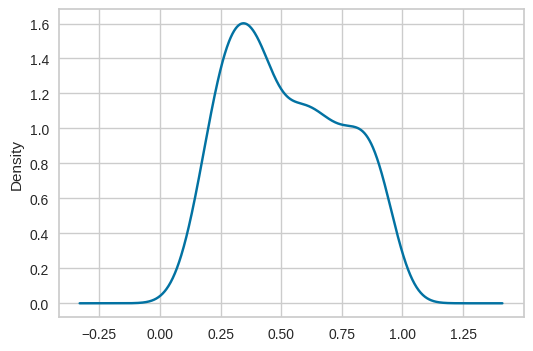

In [8]:
# COLOCAR RUN APROVACAO DE MODELO
# PARAMETROS: min_precision
# METRICS: new_version, precision
# ARTIFACTS: None

with mlflow.start_run(experiment_id=experiment_id, run_name = 'AprovacaoModelo'):
    pred_holdout = pc.predict_model(bestmodel, raw_score=True)
    pred_holdout.drop('prediction_score_0', axis=1, inplace=True)
    pred_holdout.rename({'prediction_score_1': 'prediction_score'}, axis=1, inplace=True)
    pr = metrics.precision_score(pred_holdout[wine_target_col], pred_holdout['prediction_label'])
    if pr > min_precision:
        print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
        pred_holdout.to_parquet('modelo_vinho_teste.parquet')
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(data_wine.drop(wine_target_col, axis=1).columns)
        inf_signature = infer_signature(data_wine[model_features], 
                                        model_pipe.predict(data_wine.drop(wine_target_col, axis=1)))
        # Exemplo de entrada para o MLmodel
        input_example = {x: data_wine[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.set_registered_model_alias(
            name    = registered_model_name, 
            alias   = "staging", 
            version = model_version
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_precision)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("precisao", pr)

    
    # # 
    plt.figure(figsize=(6,4))
    pred_holdout.prediction_score.plot.kde()
    plt.savefig('teste_saida_modelo.png')
    mlflow.log_artifact('teste_saida_modelo.png')
    os.remove('teste_saida_modelo.png')

mlflow.end_run()

In [9]:
# from pprint import pprint

# client = MlflowClient()
# for rm in client.search_registered_models():
#     pprint(dict(rm), indent=4)


# Serviço do Modelo 

In [10]:
# import os
# os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
export MLFLOW_TRACKING_URI=sqlite:///mlruns.db
mlflow models serve -m "models:/modelo_vinho_tinto@staging" --no-conda -p 5001

# Operação Sistema de Recomendação de Vinhos 

In [11]:
import requests
import json

host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

inference_request = {
    "dataframe_split": json.loads(data_operation.drop(wine_target_col,axis=1).to_json(orient='split'))
}
r = requests.post(url=url, headers=headers, json=inference_request)

data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

data_operation.to_parquet('modelo_vinho_operacao.parquet')
data_operation[data_operation.operation_label == 1].sort_values('alcohol', ascending=False).head(5)

,alcohol,volatile acidity,free sulfur dioxide,residual sugar,target,operation_label
948,13.600000,0.40,29.0,4.3,1,1
1251,13.566667,0.47,16.0,2.2,1,1
958,13.500000,0.29,3.0,1.7,1,1
431,13.400000,0.40,13.0,2.6,1,1
950,13.300000,0.39,14.0,2.1,1,1


# Revalidacao de Amostras para Monitoramento

In [12]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:

# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 250

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('modelo_vinho_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('modelo_vinho_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[wine_target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[wine_target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       130
           1       0.71      0.64      0.68       120

    accuracy                           0.70       250
   macro avg       0.71      0.70      0.70       250
weighted avg       0.70      0.70      0.70       250



## Alarme de Desvio 

In [13]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):
    plt.figure(figsize=(6,4))
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Densidade')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

## Alarme de Retreinamento

In [14]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[wine_target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[wine_target_col], testset['prediction_label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

### Monitoramento Base Operacao 

In [15]:
# COLOCAR RUN MONITORAMENTO OPERACAO
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('modelo_vinho_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'volatile acidity' # 'alcohol'
    data_drift_alarm(var_name, data_wine, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

== ALARME DE RETREINAMENTO - BASE CONTROLE ==
	=> especificidade de teste 0.847682119205298 e de controle 0.7615384615384615
	=> MODELO OPERANDO FORA DO ESPERADO
	=> sensibilidade de teste 0.7727272727272727 e de controle 0.6416666666666667
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.8553459119496856 e de controle 0.7129629629629629
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


# Operação Aplicação Python 

### Monitoramento Base de Novidade

In [16]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_vinho_tinto@staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('modelo_vinho_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty.drop(wine_target_col,axis=1))
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'volatile acidity' # 'alcohol'
    data_drift_alarm(var_name, data_wine, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    # LOG ARTEFATO
    var_name = 'alcohol'
    data_drift_alarm(var_name, data_wine, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run()  

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.847682119205298 e de controle 0.5689910979228486
	=> MODELO OPERANDO FORA DO ESPERADO
	=> sensibilidade de teste 0.7727272727272727 e de controle 0.7558362035973977
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.8553459119496856 e de controle 0.7726917057902973
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NECESSARIO
